# Simple IMPT plan optimization

In [10]:
import math
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import IMPTPlanOptimizer

## CT calibration and BDL

In [11]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

## Create synthetic CT and ROI

In [12]:
patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

## Configure dose engine

In [13]:
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

mc2._independentScoringGrid = True
scoringSpacing = [2, 2, 2]
mc2._scoringVoxelSpacing = scoringSpacing

## Design plan

In [14]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

planInit = PlanDesign()
planInit.ct = ct
planInit.targetMask = roi
planInit.gantryAngles = gantryAngles
planInit.beamNames = beamNames
planInit.couchAngles = couchAngles
planInit.calibration = ctCalibration
planInit.spotSpacing = 6.0
planInit.layerSpacing = 6.0
planInit.targetMargin = 0.0
planInit.setScoringParameters(scoringSpacing=[2, 2, 2], adapt_gridSize_to_new_spacing=True)

plan = planInit.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
plan.planDesign.beamlets = beamlets
doseImageRef = beamlets.toDoseImage()

07/08/2023 03:39:57 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
07/08/2023 03:39:57 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 0.0 mm. This process might take some time.
07/08/2023 03:39:57 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
07/08/2023 03:39:59 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 1.9748172760009766 sec
07/08/2023 03:39:59 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 84
07/08/2023 03:39:59 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
07/08/2023 03:40:02 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
07/08/2023 03:40:02 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil

MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.609962 s 


Simulation of beamlet 80/84  
MC computation time: 2.834307 s 
Output computation time: 0.008475 s 

Simulation of beamlet 82/84  
MC computation time: 2.878412 s 
Output computation time: 0.006985 s 

Simulation of beamlet 71/84  
MC computation time: 2.907636 s 
Output computation time: 0.006633 s 

Simulation of beamlet 79/84  
MC computation time: 2.918044 s 
Output computation time: 0.007161 s 

Simulation of beamlet 84/84  
MC computation time: 2.937111 s 
Output computation time: 0.007437 s 

Simulation of beamlet 83/84  
MC computation time: 2.941360 s 
Output computation time: 0.007217 s 

Simulation of beamlet 81/84  
MC computation time: 2.943898 s 
Output computation time: 0.006725 s 

Simulation of beamlet 76/84  
MC computation time: 2.957948 s 
Output computation time: 0.007042 s 

Simulation of beamlet 72/84  
MC computation time: 2.969313 s 
Output computation time: 0.007027 s 

Simulation of beamlet 78/84  
MC computation time: 2.

## Objectives

In [15]:
plan.planDesign.objectives = ObjectivesList()
plan.planDesign.objectives.setTarget(roi.name, 20.0)

plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.0, 1.0)

## Optimize plan

In [16]:
solver = IMPTPlanOptimizer(method='Scipy-LBFGS', plan=plan, maxit=50)
w, doseImage, ps = solver.optimize()

plan.spotMUs = np.square(w).astype(np.float32)

07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           84     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13270D+02    |proj g|=  5.11995D+00
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 1 of Scipy-L-BFGS-B

At iterate    1    f=  4.44802D+01    |proj g|=  2.21094D+00
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 4.448019e+01  
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 2 of Scipy-L-BFGS-B

At iterate    2    f=  3.56471D+01    |proj g|=  2.90466D+00
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 3.564709e+01  
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimizatio

 This problem is unconstrained.


07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 21 of Scipy-L-BFGS-B

At iterate   21    f=  5.88297D+00    |proj g|=  4.32242D-02
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 5.882969e+00  
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 22 of Scipy-L-BFGS-B

At iterate   22    f=  5.87641D+00    |proj g|=  2.75826D-02
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 5.876405e+00  
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 23 of Scipy-L-BFGS-B
At iterate   23    f=  5.86797D+00    |proj g|=  2.42386D-02
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 5.867966e+00  
07/08/2023 03:40:11 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 24 of Scipy-L-B

## Final dose computation

In [17]:
mc2.nbPrimaries = 1e7
doseImage = mc2.computeDose(ct, plan)

07/08/2023 03:40:11 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
07/08/2023 03:40:11 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
07/08/2023 03:40:11 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
07/08/2023 03:40:12 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.593932 s 


Simulation started (2023-08-07 15:40:13) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 0.62 %) 
 60.0 % (stat uncertainty: 0.58 %) 
 70.0 % (stat uncertainty: 0.55 %) 
 80.0 % (stat uncertainty: 0.53 %) 
 90.0 % (stat uncertainty: 0.50 %) 
 100.0 % (stat uncertainty: 0.48 %) 

Nbr primaries simulated: 10000000 (98374 generated outside the geometry) 
MC computation time: 14.614585 s 
Output computation time: 0.002100 s 

Total computation time: 15.210630 s 


## Plots

D95 = 14.85595703125 Gy
D5 = 23.08349609375 Gy
D5 - D95 =  8.2275390625 Gy
07/08/2023 03:40:28 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


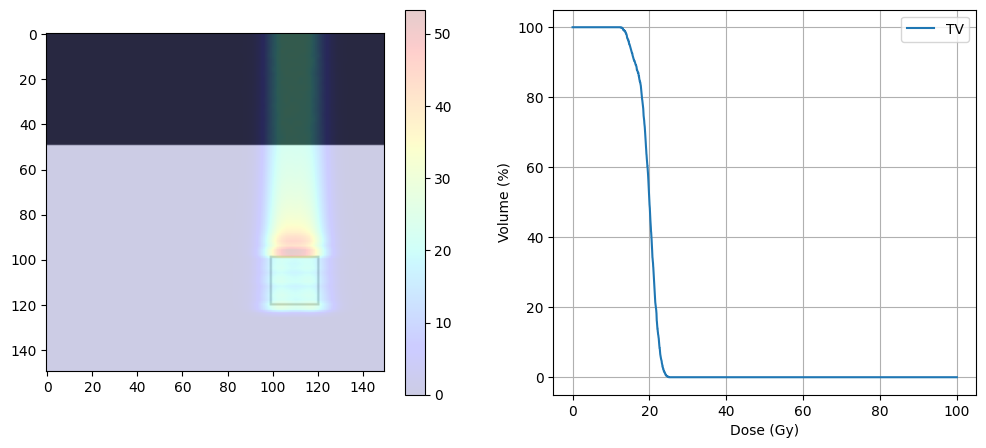

In [18]:
 # Compute DVH on resampled contour
roiResampled = resampleImage3D(roi, origin=ct.origin, spacing=scoringSpacing)
target_DVH = DVH(roiResampled, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax[0].axes.get_xaxis().set_visible(False)
#ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()

plt.show()